# Classifying Fashion MNIST with a Neural Network

Fashion MNIST is a dataset of article images from the fashion company Zalando. It was created to be a more challenging drop-in replacement for the classic MNIST (handwritten digits) dataset. It consists of 60,000 training images and 10,000 testing images, each a 28x28 grayscale image associated with a label from one of 10 classes.
In this lab, we will build, train, and evaluate a neural network to classify these fashion images.

## 1. Importing the Libraries
First, let's import all the necessary libraries.

In [1]:
# Standard PyTorch and data handling libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

# Libraries for visualization
import matplotlib.pyplot as plt
import numpy as np

# Ensure our plots are displayed in the notebook
%matplotlib inline

# 2. Load the Dataset 

PyTorch's torchvision library provides easy access to many common datasets, including FashionMNIST.

We also need to define a transform. transforms.ToTensor() is a crucial step that:
- Converts the input images (which are in a Python Imaging Library format) into PyTorch tensors.
- Scales the pixel values from a range of [0, 255] to a floating-point range of [0.0, 1.0]. In this range, inputs are numerically stable, statistically consistent, and conducive to efficient gradient-based learning.

> list of transformations that needs to be done on the input image as a part of pre-processing can be implemented using transforms.compose

In [2]:
# Load the training data
train_set = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    # Define a set of transformations to apply to the images
    transform = transforms.Compose([
        transforms.Resize((28, 28)), # Resize images to 28x28 pixels
        transforms.ToTensor(),
    ])
)

# Load the test data
test_set = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    # Define a set of transformations to apply to the images
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])
)

# 3. DataLoader for passing data in batches
Dataset class in pytorch basically covers the data in a tuple and enables us to access the index of each data.

To train a model, we need to pass this data in batches. The DataLoader is a powerful utility that handles:
- Grouping data into batches.
- Shuffling the data every epoch to prevent the model from learning the order of the data.
- Using multiple workers to load data in parallel.

We can also show some figures for visualization.

In [3]:
# Create the Dataloader for the training set
train_loader = DataLoader(
    dataset = train_set,
    batch_size = 128,
    shuffle = True
)

# Create the Dataloader for the test set
test_loader = DataLoader(
    dataset = test_set,
    batch_size = 128,
    shuffle = False
)

Let's visualize a batch of our training data to see what we're working with

In [4]:
# Define the human-readable labels
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot",
}

Labels for this batch: ['Shirt', 'Sneaker', 'Bag', 'Shirt', 'Pullover', 'Sneaker', 'Sandal', 'Bag']


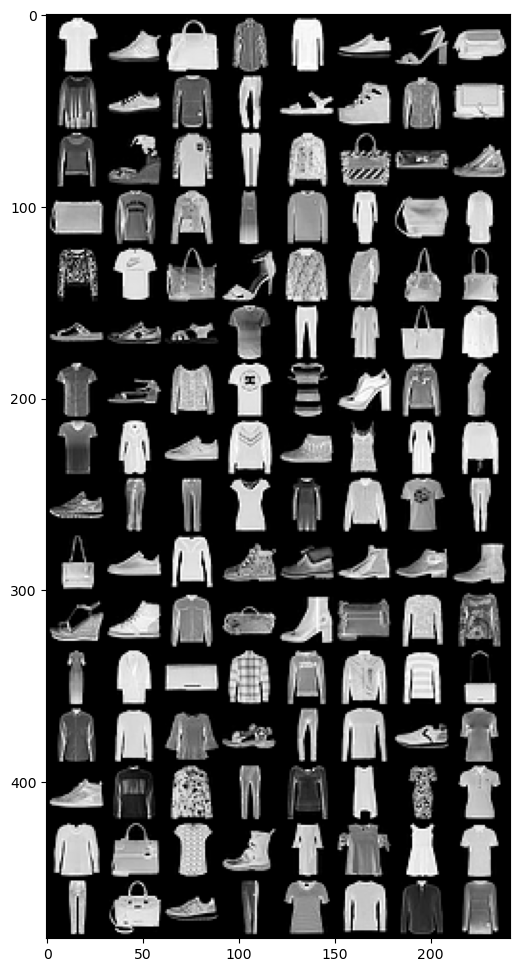

In [5]:
# Get a single batch of training images
images, labels = next(iter(train_loader))

# Create a grid of images
grid = torchvision.utils.make_grid(images, nrow=8)

# Plot the images
plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("Labels for this batch:", [labels_map[label.item()] for label in labels[:8]])

# 4. Define the Neural Network Model
Here, we define the NeuralNetwork as the same as in Lab session **4.2**

In [6]:
# Set the device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Instantiate the model and move it to the correct device
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Note: we just defined the simple network model with linear function, you can implement any other structures based on the pytorch framework.

# 5. Set up hyper-parameter and create train and test loops

Before training, we need to define our loss function, optimizer, and the number of epochs.

- **Loss** Function: We use CrossEntropyLoss because this is a multi-class classification problem.
- **Optimizer**: We'll use Stochastic Gradient Descent (SGD), a classic and effective optimizer.
- **Epochs**: An epoch is one full pass through the entire training dataset.


In [7]:
# Hyperparameters
learning_rate = 1e-2
epochs = 10

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

To keep our code organized, we'll create two functions: one for the training loop and one for the testing/evaluation loop.

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    # Put the model in training mode
    model.to(device)
    model.train()


    total_samples = 0
    train_loss = 0
    train_accuracy = 0

    

    for images, labels in dataloader:
        # Move data to the correct device
        images, labels = images.to(device), labels.to(device)
        batch_size = images.shape[0]
        total_samples += batch_size

        # Forward pass: compute predicted outputs by passing inputs to the model
        predictions = model(images)

        # Loss
        loss = loss_fn(predictions, labels)

        # Zero the gradients before running the backward pass
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Log accuracy and loss
        acc = (predictions.argmax(1) == labels).type(torch.float).sum().item()
        train_accuracy += acc
        train_loss += loss.item() * batch_size

    train_loss /= total_samples
    train_accuracy /= total_samples

    return train_loss, train_accuracy


def test_loop(dataloader, model, loss_fn, device):
    model.to(device)
    # Put the model in evaluation mode
    model.eval()

    total_samples = 0
    test_loss = 0
    test_accuracy = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for images, labels in dataloader:
            # Move data to the correct device
            images, labels = images.to(device), labels.to(device)
            batch_size = images.shape[0]
            total_samples += batch_size

            # Forward pass: compute predicted outputs by passing inputs to the model
            predictions = model(images)
            acc = (predictions.argmax(1) == labels).type(torch.float).sum().item()
            test_accuracy += acc
            loss = loss_fn(predictions, labels)
            test_loss += loss.item() * batch_size

    test_loss /= total_samples
    test_accuracy /= total_samples
    print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, test_accuracy


# 6. Train the network
When all things are ready, we can train the network now. 

When feeding dataset into the network , we calculate the loss and use the gradient to update the weights by minimizing the loss function. 
We just simply repeat the process several times.

In [9]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer, device)

    if t % 1 == 0:
        test_loss, test_accuracy = test_loop(test_loader, model, loss_fn, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 63.6%, Avg loss: 1.082001 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 69.1%, Avg loss: 0.787614 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.689098 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.626275 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 79.8%, Avg loss: 0.581430 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.554733 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 81.4%, Avg loss: 0.534273 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.526622 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 82.3%, Avg loss: 0.506044 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.503668 

Done!


# 7 . Making a Prediction for A Sample from Test Set



We have trained the network over the training dataset. 
Now, we can check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.
Hence, we can calculate the accuracy of the model on the test data.

For the details, let us display an image from the test data firstly.


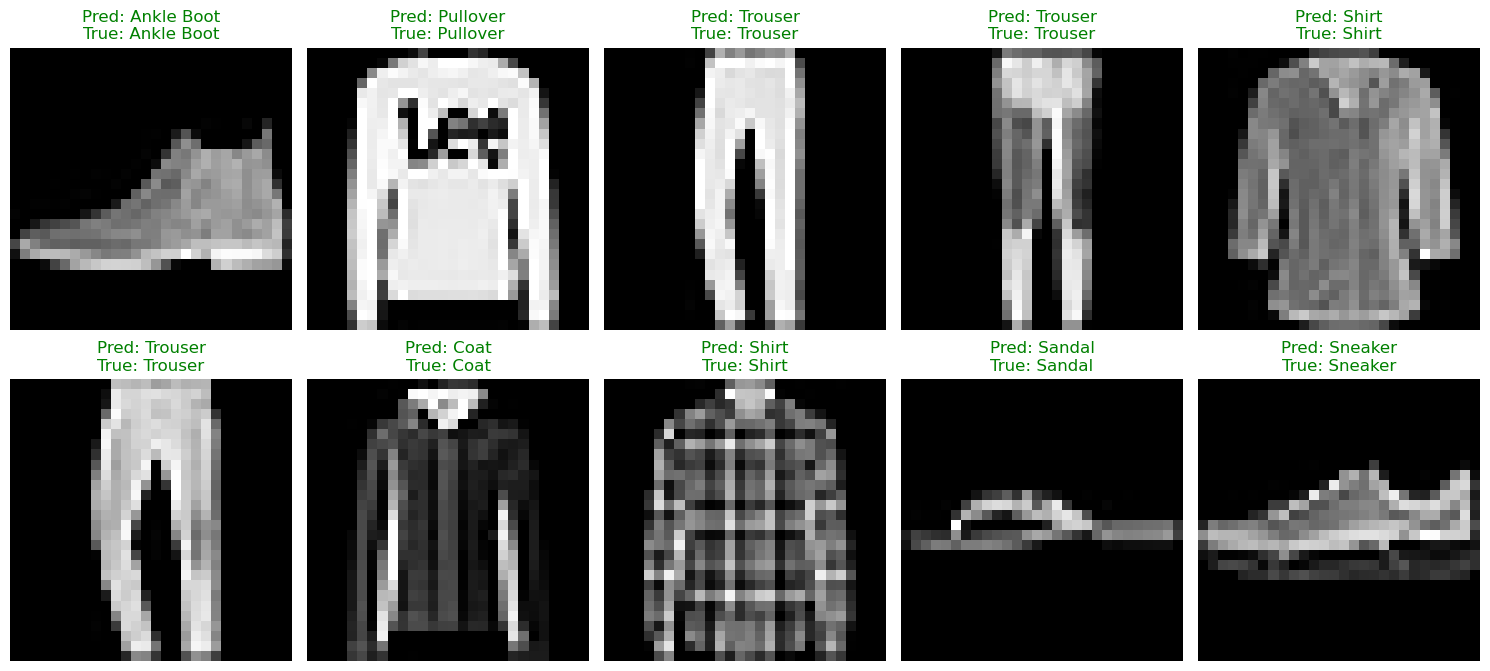

In [10]:
# Set the model to evaluation mode
model.eval()

# Get a batch of test data
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get model predictions for this batch
with torch.no_grad():
    outputs = model(images)
    # Get the predicted class by finding the index of the maximum logit
    predicted_classes = outputs.argmax(dim=1)

# Plot the images with their predicted and true labels
plt.figure(figsize=(15, 7))
for i in range(10): # Display the first 10 images of the batch
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].cpu().reshape(28, 28), cmap="gray")
    predicted_label = labels_map[predicted_classes[i].item()]
    true_label = labels_map[labels[i].item()]
    color = "green" if predicted_label == true_label else "red"
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

# 8. Model Performance Analysis
Let us look at how the network performs on the whole dataset.

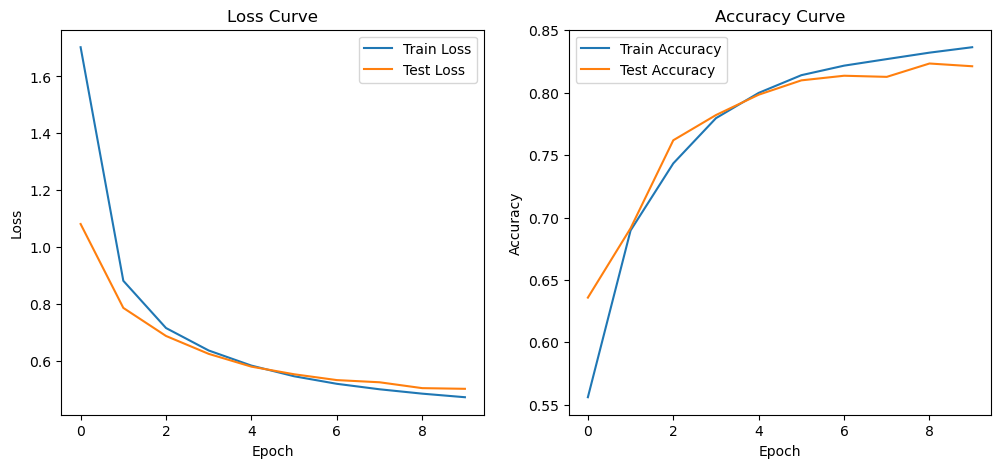

In [11]:
# Plot the learning curve and losses
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

<b>Note:</b> 
We use the line plots to show epochs along the ``x-axis`` and the loss error on the ``y-axis``. 
These plots are sometimes called learning curves. These plots can help to diagnose whether the model has over learned, under learned, or is suitably fit to the training dataset. What do you observe from the plots below? Is the model overfitting, underfitting, or well-fitted? How could we improve the model performance? Think about these as you will do a lab by yourself later.


# Conclusion
The model’s accuracy is found to be 88% on the test set. 

In this lab, we successfully built and trained a neural network that achieves a respectable accuracy on the FashionMNIST test set. This demonstrates the power of neural networks for image classification tasks.
It's important to note that our simple, fully-connected network does not look at the spatial structure of the images. More advanced architectures, like Convolutional Neural Networks (CNNs), are specifically designed for image data and use features like parameter sharing and edge-detection to achieve much higher accuracy
